In [1]:
# Standard imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time

# Add mavenn to the path
import sys
sys.path.insert(0, '../')

# Import mavenn
import mavenn
# Load model
model = mavenn.load_example_model('gb1_ge_additive')

Model loaded from these files:
	/Users/jkinney/github/mavenn/scratch/../mavenn/examples/models/gb1_ge_additive.pickle
	/Users/jkinney/github/mavenn/scratch/../mavenn/examples/models/gb1_ge_additive.weights.h5


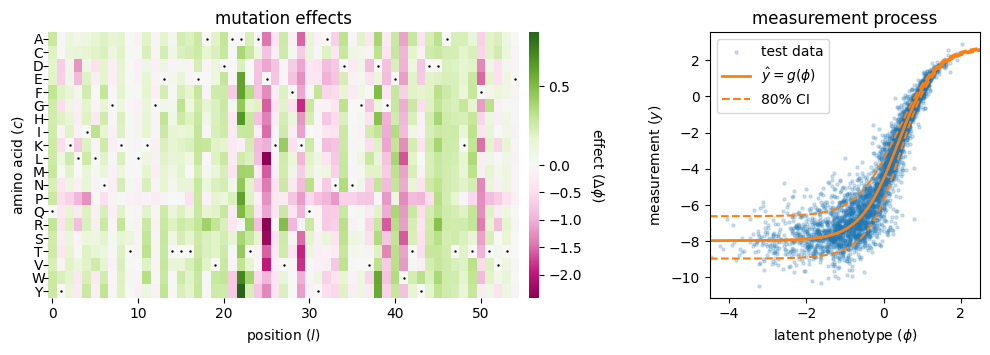

In [4]:


# Set wild-type sequence
gb1_seq = model.x_stats['consensus_seq']

# Get effects of all single-point mutations on phi
theta_dict = model.get_theta(gauge='user', x_wt=gb1_seq)

# Load data as dataframe
data_df = mavenn.load_example_dataset('gb1')

# Extract test data
ix = (data_df['set']=='test')
test_df = data_df[ix]

# Subsample test data, just to make plotting faster
N_test = len(test_df)
N_sample = 5000
ix = np.random.choice(N_test, size=N_sample, replace=False).astype(int)
x = test_df['x'].values[ix]
y = test_df['y'].values[ix]

# Compute phi and yhat values
phi = model.x_to_phi(x)
yhat = model.phi_to_yhat(phi)

# Create grid for plotting yhat and yqs
phi_lim = [-4.5, 2.5]
phi_grid = np.linspace(phi_lim[0], phi_lim[1], 1000)
yhat_grid = model.phi_to_yhat(phi_grid)
yqs_grid = model.yhat_to_yq(yhat_grid, q=[.10,.90])

# Create two panels
fig = plt.figure(figsize=[10,  3.65])
gs = fig.add_gridspec(1, 5)

# Left panel: draw heatmap illustrating 1pt mutation effects
ax = fig.add_subplot(gs[:3])
ax, cb = mavenn.heatmap(theta_dict['theta_lc'],
                        alphabet=theta_dict['alphabet'],
                        seq=gb1_seq,
                        cmap='PiYG',
                        ccenter=0,
                        ax=ax,
                        cmap_size='2%')
ax.set_xlabel(r'position ($l$)')
ax.set_ylabel(r'amino acid ($c$)')
ax.set_title(r'mutation effects')
cb.set_label(r'effect ($\Delta\phi$)', rotation=-90, va="bottom")
cb.outline.set_visible(False)

# Right panel: illustrate measurement process with GE curve
ax = fig.add_subplot(gs[3:])
ax.scatter(phi, y, color='C0', s=5, alpha=.2, label='test data')
ax.plot(phi_grid, yhat_grid, linewidth=2, color='C1',
        label=r'$\hat{y} = g(\phi)$')
ax.plot(phi_grid, yqs_grid[:, 0], linestyle='--', color='C1',
        label='80% CI')
ax.plot(phi_grid, yqs_grid[:, 1], linestyle='--', color='C1')
ax.set_xlim(phi_lim)
ax.set_xlabel(r'latent phenotype ($\phi$)')
ax.set_ylabel(r'measurement ($y$)')
ax.set_title(r'measurement process')
ax.legend()

# Fix up plot
fig.tight_layout(w_pad=3)
fig.savefig('gb1_ge_evaluation.png')
plt.show()
